In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import pandas as pd
import sentencepiece as spm
import time
import numpy as np

### 토큰화 방법: Sentencepiece

<h3> Sentencepiece 모듈 파라미터</h3>

- input : 학습시킬 파일
- model_prefix : 만들어질 모델 이름
- vocab_size : 단어 집합의 크기
    - 너무 적으면 한 글자 단위로 쪼개지는 경향이 있고, 너무 많으면 쓸데없는 단어들이 만들어진다. 주로 32,000이 가장 좋다고 알려져 있다.
- model_type : 사용할 모델 (unigram(default), bpe, char, word)\
- max_sentence_length: 문장의 최대 길이
- pad_id, pad_piece: pad token id, 값
- unk_id, unk_piece: unknown token id, 값
- bos_id, bos_piece: begin of sentence token id, 값
- eos_id, eos_piece: end of sequence token id, 값
- user_defined_symbols: 사용자 정의 토큰

## Experiment 1. 텍스트 전처리 전 토큰화 및 임베딩
- 성능 실험을 위해 정제된 dacon news data를 이용해 뉴스 카테고리 (이진)분류 모델의 성능을 확인할 예정

In [113]:
dacon_df = pd.read_csv('/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_news_data.csv')
dacon_df = dacon_df[['title', 'topic_idx']]
dacon_df.head()

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [114]:
dacon_df.shape

(14991, 2)

In [115]:
dacon_df['topic_idx'] = dacon_df['topic_idx'].replace(4, 0)
dacon_df['topic_idx'] = dacon_df['topic_idx'].replace(2, 1)
dacon_df['topic_idx'].value_counts()

0    7629
1    7362
Name: topic_idx, dtype: int64

In [116]:
with open('/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_title.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(dacon_df['title']))
    
input_file = '/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_title.txt'
vocab_size = 32000
prefix = '/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_sentencepiece'
model_type = 'bpe'

templates = '--input={} --model_prefix={} --vocab_size={} --model_type={}'
cmd = templates.format(input_file, prefix, vocab_size, model_type)
cmd

'--input=/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_title.txt --model_prefix=/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_sentencepiece --vocab_size=32000 --model_type=bpe'

In [117]:
# 토큰화 time check
start = time.time() 

# model train
spm.SentencePieceTrainer.Train(cmd) # train 후 .vocab과 .model 2개 파일 생성

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 14.115135908126831


In [118]:
# model load

sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(prefix))

# 토큰화 확인
for t in dacon_df['title'][:1]:
    print(t, "\n")
    print(sp.encode_as_pieces(t),"\n") #문장을 입력하면 서브 워드 시퀀스로 변환
    print(sp.encode_as_ids(t), "\n") #문장을 입력하면 정수 시퀀스로 변환

인천→핀란드 항공기 결항…휴가철 여행객 분통 

['▁인천', '→', '핀', '란드', '▁항공기', '▁결항', '...', '휴가철', '▁여행객', '▁분통'] 

[415, 31319, 31253, 656, 3776, 5307, 4, 26016, 7630, 8607] 



In [120]:
dacon_df['tokenized_sent'] = dacon_df['title'].apply(lambda s: sp.encode_as_pieces(s))
dacon_df['encoding'] = dacon_df['title'].apply(lambda s: sp.encode_as_ids(s))

In [121]:
dacon_df.head(3)

,title,topic_idx,tokenized_sent,encoding
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,0,"[▁인천, →, 핀, 란드, ▁항공기, ▁결항, ..., 휴가철, ▁여행객, ▁분통]","[415, 31319, 31253, 656, 3776, 5307, 4, 26016,..."
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,0,"[▁실리콘밸리, ▁넘어서, 겠다, ..., 구글, ▁15, 조원, ▁들여, ▁美, ...","[7907, 16412, 654, 4, 5148, 556, 1106, 7131, 1..."
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,0,"[▁이란, ▁외무, ▁긴장완화, ▁해결책은, ▁미국이, ▁경제전쟁, ▁멈추는, ▁것]","[37, 444, 18208, 19245, 5605, 12316, 21337, 141]"


### RNN을 이용한 뉴스 토픽 분류

In [122]:
with open("/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_sentencepiece.vocab", 'r') as f:
    vocab = f.readlines()

word_index = {}
index_word = {}

for idx, line in enumerate(vocab):
    word = line.split("\t")[0]

    word_index.update({idx:word})
    index_word.update({word:idx})

메일의 최대 길이 : 22
메일의 평균 길이 : 9.915683


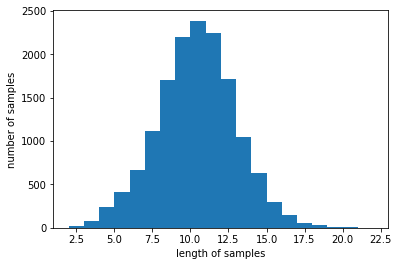

In [124]:
import matplotlib.pyplot as plt

sequences = dacon_df['encoding']
X_data = sequences

print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [125]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 22
X_data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", X_data.shape)

훈련 데이터의 크기(shape):  (14991, 22)


In [127]:
X_data[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   415, 31319, 31253,   656,  3776,  5307,
            4, 26016,  7630,  8607],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  7907, 16412,   654,     4,  5148,   556,  1106,  7131,
           14, 30768, 30871, 25015],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    37,   444, 18208, 19245,
         5605, 12316, 21337,   141]], dtype=int32)

In [126]:
# ndarray로 바꿔주기
y_data = np.array(list(dacon_df['topic_idx']))
y_data[:3]

array([0, 0, 0])

In [129]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(11992, 22) (11992,)
(2999, 22) (2999,)


In [130]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
from tensorflow import keras

model = Sequential()
model.add(Embedding(32000, 32))
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [131]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 32)          1024000   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 1,026,113
Trainable params: 1,026,113
Non-trainable params: 0
_________________________________________________________________


In [139]:
history = model.fit(X_train, Y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
150/150 [==============================] - 3s 18ms/step - loss: 8.6051e-05 - accuracy: 1.0000 - val_loss: 0.4095 - val_accuracy: 0.9283
Epoch 2/4
150/150 [==============================] - 3s 17ms/step - loss: 7.5261e-05 - accuracy: 1.0000 - val_loss: 0.4184 - val_accuracy: 0.9283
Epoch 3/4
150/150 [==============================] - 3s 18ms/step - loss: 6.6148e-05 - accuracy: 1.0000 - val_loss: 0.4316 - val_accuracy: 0.9258
Epoch 4/4
150/150 [==============================] - 3s 18ms/step - loss: 5.7062e-05 - accuracy: 1.0000 - val_loss: 0.4375 - val_accuracy: 0.9279


In [140]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, Y_test)[1]))

94/94 [==============================] - 0s 2ms/step - loss: 0.4820 - accuracy: 0.9193

 테스트 정확도: 0.9193


## Experiment 2. 텍스트 전처리 후 토큰화 및 임베딩

In [146]:
dacon_df2 = pd.read_csv('/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_news_data.csv')
dacon_df2 = dacon_df2[['title', 'topic_idx']]

# 한글, 영어 제외한 문자 제거
dacon_df2['title'] = dacon_df2['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-z ]"," ") 

# topic_idx 숫자 변화
dacon_df2['topic_idx'] = dacon_df['topic_idx'].replace(4, 0)
dacon_df2['topic_idx'] = dacon_df['topic_idx'].replace(2, 1)

dacon_df2.head()

,title,topic_idx
0,인천 핀란드 항공기 결항 휴가철 여행객 분통,0
1,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화,0
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,0
3,NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,0
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,0


In [147]:
with open('/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_title2.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(dacon_df2['title']))
    
input_file = '/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_title2.txt'
vocab_size = 32000
prefix = '/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_sentencepiece2'
model_type = 'bpe'

templates = '--input={} --model_prefix={} --vocab_size={} --model_type={}'
cmd = templates.format(input_file, prefix, vocab_size, model_type)

# 토큰화 time check
start = time.time() 

# model train
spm.SentencePieceTrainer.Train(cmd) # train 후 .vocab과 .model 2개 파일 생성

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 13.609874248504639


In [148]:
# model load

sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(prefix))

# 토큰화 확인
for t in dacon_df2['title'][:1]:
    print(t, "\n")
    print(sp.encode_as_pieces(t),"\n") #문장을 입력하면 서브 워드 시퀀스로 변환
    print(sp.encode_as_ids(t), "\n") #문장을 입력하면 정수 시퀀스로 변환

인천 핀란드 항공기 결항 휴가철 여행객 분통 

['▁인천', '▁핀란드', '▁항공기', '▁결항', '▁휴가철', '▁여행객', '▁분통'] 

[391, 6354, 2754, 5148, 24727, 5484, 8233] 



In [151]:
dacon_df2['tokenized_sent'] = dacon_df2['title'].apply(lambda s: sp.encode_as_pieces(s))
dacon_df2['encoding'] = dacon_df2['title'].apply(lambda s: sp.encode_as_ids(s))
dacon_df2.head(3)

,title,topic_idx,tokenized_sent,encoding
0,인천 핀란드 항공기 결항 휴가철 여행객 분통,0,"[▁인천, ▁핀란드, ▁항공기, ▁결항, ▁휴가철, ▁여행객, ▁분통]","[391, 6354, 2754, 5148, 24727, 5484, 8233]"
1,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화,0,"[▁실리콘밸리, ▁넘어서겠다, ▁구글, ▁조원, ▁들여, ▁전역, ▁거점화]","[7603, 30497, 1440, 1127, 6859, 10573, 23609]"
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,0,"[▁이란, ▁외무, ▁긴장완화, ▁해결책은, ▁미국이, ▁경제전쟁, ▁멈추는, ▁것]","[31, 400, 11786, 18332, 4372, 11739, 21136, 151]"


메일의 최대 길이 : 18
메일의 평균 길이 : 8.477153


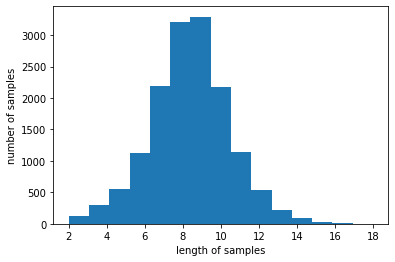

In [155]:
with open("/content/drive/MyDrive/News_Timeline_WepApp/data/dacon_sentencepiece2.vocab", 'r') as f:
    vocab = f.readlines()

word_index = {}
index_word = {}

for idx, line in enumerate(vocab):
    word = line.split("\t")[0]

    word_index.update({idx:word})
    index_word.update({word:idx})

sequences = dacon_df2['encoding']
X_data = sequences

print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=15)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [158]:
max_len = 18
X_data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", X_data.shape)

# ndarray로 바꿔주기
y_data = np.array(list(dacon_df2['topic_idx']))

print(X_data[:3])
print(y_data[:3])

훈련 데이터의 크기(shape):  (14991, 18)
[[    0     0     0     0     0     0     0     0     0     0     0   391
   6354  2754  5148 24727  5484  8233]
 [    0     0     0     0     0     0     0     0     0     0     0  7603
  30497  1440  1127  6859 10573 23609]
 [    0     0     0     0     0     0     0     0     0     0    31   400
  11786 18332  4372 11739 21136   151]]
[0 0 0]


In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(11992, 18) (11992,)
(2999, 18) (2999,)


In [160]:
model = Sequential()
model.add(Embedding(32000, 32)) 
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
150/150 [==============================] - 4s 19ms/step - loss: 0.4765 - accuracy: 0.7587 - val_loss: 0.2748 - val_accuracy: 0.8845
Epoch 2/4
150/150 [==============================] - 2s 16ms/step - loss: 0.0910 - accuracy: 0.9705 - val_loss: 0.2352 - val_accuracy: 0.9070
Epoch 3/4
150/150 [==============================] - 2s 17ms/step - loss: 0.0186 - accuracy: 0.9961 - val_loss: 0.2497 - val_accuracy: 0.9129
Epoch 4/4
150/150 [==============================] - 2s 16ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.2835 - val_accuracy: 0.9054


In [161]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, Y_test)[1]))

94/94 [==============================] - 0s 2ms/step - loss: 0.3256 - accuracy: 0.8980

 테스트 정확도: 0.8980
